# This Code Does the Following:
1) Transforms NASA ER2 flight data from latitude/longitude coordinates to low-relative coordinates for cyclones sampled during IMPACTS
2) Calculates pressure gradient for cyclones sampled during IMPACTS
3) Produces a CSV file of latitude/longitude and value of lowest pressure of the cyclone, low relative coordinates for ER2, and cyclone pressure gradient 

## Choose IOP to process

In [1]:
day='20200125'
# Year
yr=2020
# Month
m=1
#Day
d=[25]

fl_choice='ER2'

path=''

In [2]:
# Choose region to plot maps
north_lat=50
south_lat=25
east_lon=-60
west_lon=-90

## Importing packages, setting up functions, flight track information

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
from dask.distributed import Client, progress
import h5py
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib.dates import num2date
import matplotlib.dates as mdates
from pyproj import Proj
from scipy.spatial import cKDTree
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import Gridliner
import cartopy.feature as cfeature
import glob
import icartt

import metpy.calc as mpcalc
from metpy.interpolate import cross_section
from metpy.units import units
from metpy.plots import USCOUNTIES

import math as mt

from haversine import haversine, Unit

import warnings
warnings.filterwarnings("ignore")

In [5]:
def fldef(day):
    if day=='20200125':
        lowtype='MB'
        #ER2: FL start... 20:00:08, end... 23:00:00
        er2_flight_legs=[#['2020-01-25 19:17:00', '2020-01-25 19:31:07', '0'], #not actual FL
                        #['2020-01-25 19:33:00', '2020-01-25 19:56:43', '0'], 
                        ['2020-01-25 20:00:08', '2020-01-25 20:16:23', '1'],
                        ['2020-01-25 20:18:30', '2020-01-25 20:25:48', '2'],
                        ['2020-01-25 20:29:18', '2020-01-25 20:51:29', '3'],
                        ['2020-01-25 20:54:40', '2020-01-25 21:02:14', '4'],
                        ['2020-01-25 21:04:20', '2020-01-25 21:21:10', '5'],
                        ['2020-01-25 21:23:12', '2020-01-25 21:30:29', '6'],
                        ['2020-01-25 21:33:56', '2020-01-25 21:56:18', '7'],
                        ['2020-01-25 22:00:18', '2020-01-25 22:08:02', '8'],
                        ['2020-01-25 22:13:38', '2020-01-25 22:33:25', '9'],
                        ['2020-01-25 22:37:00', '2020-01-25 22:43:00', '10'],
                        ['2020-01-25 22:45:00', '2020-01-25 23:00:00', '11']]#,
                        #['2020-01-25 23:01:30', '2020-01-25 23:07:26', '0']] #not actual FL?
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200125.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200201':
        lowtype='MA'
        #ER2: FL start... 12:22:43, end... 14:08:41
        er2_flight_legs=[['2020-02-01 12:22:43', '2020-02-01 12:38:21', '1'],
                        ['2020-02-01 12:42:53', '2020-02-01 13:00:51', '2'],
                        ['2020-02-01 13:06:00', '2020-02-01 13:20:33', '3'],
                        ['2020-02-01 13:25:10', '2020-02-01 13:42:04', '4'],
                        ['2020-02-01 13:52:48', '2020-02-01 14:08:41', '5']]#,
                        #['2020-02-01 14:28:00', '2020-02-01 14:49:24', '0'],
                        #['2020-02-01 14:50:52', '2020-02-01 14:57:30', '0'],
                        #['2020-02-01 14:58:00', '2020-02-01 15:23:56', '0']]
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200201.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200205':
        lowtype='AF'
        er2_flight_legs=[['2020-02-05 20:58:00', '2020-02-05 21:31:00', '1'],
                        ['2020-02-05 21:40:30', '2020-02-05 22:16:00', '2'],
                        ['2020-02-05 22:31:30', '2020-02-05 22:59:00', '3']]
                        #['2020-02-05 23:07:30', '2020-02-05 23:14:50', '4'],
                        #['2020-02-05 23:16:00', '2020-02-05 23:24:00', '5'], #diagonal
                        #['2020-02-05 23:29:00', '2020-02-05 23:37:00', '6'], #diagonal
                        #['2020-02-05 23:47:52', '2020-02-06 00:05:00', '7']] #RTB
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200205.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200207':
        lowtype='MA'
        #ER2: FL start... 13:55:01, end... 16:13:18
        er2_flight_legs=[#['2020-02-07 13:22:00', '2020-02-07 13:52:48', '0'],
                       ['2020-02-07 13:55:01', '2020-02-07 14:29:04', '1'],
                       ['2020-02-07 14:33:00', '2020-02-07 14:52:54', '2'],
                       ['2020-02-07 14:56:27', '2020-02-07 15:04:54', '3'],
                       ['2020-02-07 15:08:20', '2020-02-07 15:24:08', '4'], 
                       ['2020-02-07 15:27:37', '2020-02-07 15:50:36', '5'],
                       ['2020-02-07 15:54:50', '2020-02-07 16:13:18', '6']]#,
                       #['2020-02-07 16:17:55', '2020-02-07 17:00:00', '0']]
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200207.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200225':
        lowtype='GPC'
        #ER2: FL start... 21:45:27, end... 01:42:04
        er2_flight_legs=[['2020-02-25 21:45:27', '2020-02-25 22:02:41', '1'],
                        ['2020-02-25 22:08:34', '2020-02-25 22:25:20', '2'], 
                        ['2020-02-25 22:28:28', '2020-02-25 22:48:16', '3'],
                        ['2020-02-25 22:52:57', '2020-02-25 23:12:54', '4'],
                        ['2020-02-25 23:18:24', '2020-02-25 23:29:00', '5'], #FL 5 and 6 are in same track but are split by a spiral
                        ['2020-02-25 23:36:00', '2020-02-25 23:43:07', '6'],
                        ['2020-02-25 23:46:00', '2020-02-26 00:05:05', '7'],
                        ['2020-02-26 00:10:35', '2020-02-26 00:20:22', '8'], 
                        ['2020-02-26 00:27:30', '2020-02-26 00:42:50', '9'], 
                        ['2020-02-26 00:50:00', '2020-02-26 01:03:44', '10'],
                        ['2020-02-26 01:07:42', '2020-02-26 01:23:26', '11'], 
                        ['2020-02-26 01:27:00', '2020-02-26 01:42:04', '12']]#, 
                        #['2020-02-26 01:45:33', '2020-02-26 01:55:00', '0']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_RevB_20200225.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200227':
        lowtype='MB'
        #ER2: FL start... 09:15:20, end... 13:04:00
        er2_flight_legs=[#['2020-02-27 08:23:00', '2020-02-27 08:30:19', '0'],
                        #['2020-02-27 08:30:55', '2020-02-27 08:55:31', '0'],
                        #['2020-02-27 08:57:09', '2020-02-27 09:14:45', '0'],
                        ['2020-02-27 09:15:20', '2020-02-27 09:45:52', '1'],
                        ['2020-02-27 09:49:03', '2020-02-27 10:16:37', '2'],
                        ['2020-02-27 10:20:23', '2020-02-27 10:49:46', '3'],
                        ['2020-02-27 10:53:06', '2020-02-27 11:20:39', '4'],
                        ['2020-02-27 11:24:05', '2020-02-27 11:45:41', '5'],
                        ['2020-02-27 11:49:05', '2020-02-27 12:09:31', '6'],
                        ['2020-02-27 12:12:42', '2020-02-27 12:27:05', '7'],
                        ['2020-02-27 12:32:26', '2020-02-27 12:45:45', '8'],
                        ['2020-02-27 12:49:49', '2020-02-27 13:04:00', '9']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_RevB_20200227.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20220119':
        lowtype='AC'
        #ER2: FL start... 12:30:00, end... 15:45:13
        er2_flight_legs=[#['2022-01-19 11:50:07', '2022-01-19 12:28:00', '0'],
                        ['2022-01-19 12:30:00', '2022-01-19 12:50:00', '1'],
                        ['2022-01-19 12:58:00', '2022-01-19 13:09:38', '2'],
                        ['2022-01-19 13:16:00', '2022-01-19 13:24:00', '3'],
                        ['2022-01-19 13:37:38', '2022-01-19 13:57:33', '4'],
                        ['2022-01-19 14:07:00', '2022-01-19 14:16:53', '5'],
                        ['2022-01-19 14:24:00', '2022-01-19 14:30:43', '6'],
                        ['2022-01-19 14:44:38', '2022-01-19 14:52:38', '7'],
                        ['2022-01-19 15:00:00', '2022-01-19 15:10:00', '8'],
                        ['2022-01-19 15:17:18', '2022-01-19 15:29:03', '9'],
                        ['2022-01-19 15:35:30', '2022-01-19 15:45:13', '10']]#,
                       #['2022-01-19 15:48:00', '2022-01-19 16:29:28', '0']]
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220119.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220129':
        lowtype='MA'
        #ER2: FL start... 23:59:56, end... 01:56:16
        er2_flight_legs=[#['2022-01-29 23:20:00', '2022-01-29 23:57:01', '0'],
                        ['2022-01-29 23:59:56', '2022-01-30 00:08:46', '1'],
                        ['2022-01-30 00:16:00', '2022-01-30 00:23:00', '2'],
                        ['2022-01-30 00:32:56', '2022-01-30 00:38:51', '3'],
                        ['2022-01-30 00:44:30', '2022-01-30 00:48:00', '4'],
                        ['2022-01-30 00:53:51', '2022-01-30 01:03:00', '5'],
                        ['2022-01-30 01:08:30', '2022-01-30 01:11:00', '6'],
                        ['2022-01-30 01:14:36', '2022-01-30 01:23:00', '7'],
                        ['2022-01-30 01:31:30', '2022-01-30 01:56:16', '8']]#,
                        #['2022-01-30 01:58:00', '2022-01-30 02:10:00', '0']]
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220129.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220203':
        lowtype='AF'
        er2_flight_legs=[#['2022-02-03 14:00:00', '2022-02-03 14:40:00', '1'], #going out
                        ['2022-02-03 14:42:30', '2022-02-03 15:17:00', '1'],
                        ['2022-02-03 15:28:00', '2022-02-03 16:04:00', '2']]
                        #['2022-02-03 16:06:00', '2022-02-03 16:32:00', '4']] #RTB
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220203.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220204':
        lowtype='AF'
        er2_flight_legs=[#['2022-02-04 12:55:00', '2022-02-04 13:35:00', '1'], #going out
                        ['2022-02-04 13:43:30', '2022-02-04 14:12:00', '1'],
                        ['2022-02-04 14:41:00', '2022-02-04 15:10:30', '2'],
                        ['2022-02-04 15:21:00', '2022-02-04 15:52:00', '3'],
                        ['2022-02-04 16:04:00', '2022-02-04 16:44:30', '4'],
                        ['2022-02-04 16:50:00', '2022-02-04 17:28:00', '5'],
                        ['2022-02-04 17:37:00', '2022-02-04 18:14:00', '6']]
                        #['2022-02-04 18:21:30', '2022-02-04 19:12:00', '8'], #RTB pt 1
                        #['2022-02-04 19:13:00', '2022-02-04 19:56:00', '9']] #RTB pt 2
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220204.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220208':
        lowtype='MA'
        #ER2 FL: start... 14:27:48, end... 16:48:40
        er2_flight_legs=[#['2022-02-08 12:28:00', '2022-02-08 12:49:30', '0'],
                        #['2022-02-08 12:51:00', '2022-02-08 14:02:30', '0'],
                        ['2022-02-08 14:27:48', '2022-02-08 14:47:00', '1'],
                        ['2022-02-08 14:48:00', '2022-02-08 15:08:00', '2'],
                        ['2022-02-08 15:10:38', '2022-02-08 15:26:30', '3'],
                        ['2022-02-08 15:30:00', '2022-02-08 15:37:30', '4'],
                        ['2022-02-08 15:42:30', '2022-02-08 16:11:00', '5'],
                        ['2022-02-08 16:21:13', '2022-02-08 16:48:40', '6']]#,
                        #['2022-02-08 16:52:30', '2022-02-08 17:30:00', '0']]
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220208.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220213':
        lowtype='AF'
        er2_flight_legs=[#['2022-02-13 12:10:00', '2022-02-13 12:55:00', '1'], #going out
                        #['2022-02-13 12:56:30', '2022-02-13 13:03:00', '2'],
                        #['2022-02-13 13:15:50', '2022-02-13 13:31:00', '3'],
                        #['2022-02-13 13:32:00', '2022-02-13 13:41:00', '4'],
                        ['2022-02-13 13:44:00', '2022-02-13 14:02:00', '1'],
                        ['2022-02-13 14:09:30', '2022-02-13 14:20:55', '2'],
                        ['2022-02-13 14:29:40', '2022-02-13 14:38:30', '3']]
                        #['2022-02-13 14:44:00', '2022-02-13 15:23:00', '8']] #RTB
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220213.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220217':
        lowtype='AF'
        er2_flight_legs=[#['2022-02-17 16:50:00', '2022-02-17 17:32:00', '1'], #going out
                        ['2022-02-17 17:35:00', '2022-02-17 17:56:30', '1'],
                        ['2022-02-17 18:03:00', '2022-02-17 18:23:00', '2'],
                        #['2022-02-17 18:27:30', '2022-02-17 18:32:30', '4'],
                        #['2022-02-17 18:35:50', '2022-02-17 18:40:00', '5'],
                        #['2022-02-17 18:44:10', '2022-02-17 18:49:30', '6'],
                        #['2022-02-17 18:51:10', '2022-02-17 18:53:00', '7'],
                        #['2022-02-17 18:54:30', '2022-02-17 18:58:00', '8'],
                        ['2022-02-17 19:04:00', '2022-02-17 19:29:00', '3'],
                        ['2022-02-17 19:44:10', '2022-02-17 19:57:30', '4'],
                        ['2022-02-17 20:12:00', '2022-02-17 20:34:00', '5'],
                        ['2022-02-17 20:43:30', '2022-02-17 21:02:00', '6'],
                        ['2022-02-17 21:13:30', '2022-02-17 21:34:00', '7'],
                        ['2022-02-17 21:40:30', '2022-02-17 21:59:00', '8'],
                        ['2022-02-17 22:12:00', '2022-02-17 22:32:00', '9']]
                        #['2022-02-17 22:39:00', '2022-02-17 23:32:00', '16']] #RTB
                
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220217.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220225':
        lowtype='MB'
        #ER2 FL: start... 09:18:00, end... 13:24:30
        er2_flight_legs=[#['2022-02-25 08:50:00', '2022-02-25 08:59:00', '0'],
                        #['2022-02-25 09:01:00', '2022-02-25 09:07:00', '0'],
                        #['2022-02-25 09:09:00', '2022-02-25 09:17:00', '0'],
                        ['2022-02-25 09:18:00', '2022-02-25 09:34:00', '1'],
                        ['2022-02-25 09:42:00', '2022-02-25 09:59:30', '2'],
                        ['2022-02-25 10:06:30', '2022-02-25 10:25:00', '3'],
                        ['2022-02-25 10:33:30', '2022-02-25 10:51:00', '4'],
                        ['2022-02-25 11:00:30', '2022-02-25 11:16:20', '5'],
                        ['2022-02-25 11:24:30', '2022-02-25 11:42:30', '6'],
                        ['2022-02-25 11:52:00', '2022-02-25 12:08:00', '7'],
                        ['2022-02-25 12:16:30', '2022-02-25 12:33:00', '8'],
                        ['2022-02-25 12:41:00', '2022-02-25 12:58:50', '9'],
                        ['2022-02-25 13:08:14', '2022-02-25 13:24:30', '10']]#,
                        #['2022-02-25 13:26:00', '2022-02-25 14:05:00', '0']]
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220225.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'
    
    if day=='20230113':
        lowtype='GPC'
        er2_flight_legs=[#['2023-01-13 04:24:56', '2023-01-13 05:45:00', '0'],
                        ['2023-01-13 05:49:00', '2023-01-13 06:17:30', '1'],
                        ['2023-01-13 06:30:00', '2023-01-13 06:53:30', '2'],
                        ['2023-01-13 07:05:00', '2023-01-13 07:30:00', '3'],
                        ['2023-01-13 07:38:00', '2023-01-13 08:07:30', '4'],
                        ['2023-01-13 08:18:00', '2023-01-13 08:32:00', '5'],
                        ['2023-01-13 08:44:30', '2023-01-13 08:59:32', '6']]#,
                        #['2023-01-13 09:11:00', '2023-01-13 10:32:00', '0', '0']]
                
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230113.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
   
    if day=='20230115':
        lowtype='MA'
        er2_flight_legs=[['2023-01-15 15:02:00', '2023-01-15 15:21:58', '1'],
                        ['2023-01-15 15:31:44', '2023-01-15 15:36:33', '2'],
                        ['2023-01-15 16:06:05', '2023-01-15 16:25:29', '3'],
                        ['2023-01-15 16:45:29', '2023-01-15 17:06:59', '4'],
                        ['2023-01-15 17:14:54', '2023-01-15 17:36:19', '5'],
                        ['2023-01-15 17:45:00', '2023-01-15 18:11:39', '6'],
                        ['2023-01-15 18:14:00', '2023-01-15 18:48:39', '7']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230115.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230119':
        lowtype='GPC'
        er2_flight_legs=[['2023-01-19 21:40:51', '2023-01-19 22:06:00', '1'],
                        ['2023-01-19 22:20:30', '2023-01-19 22:44:00', '2'],
                        ['2023-01-19 23:05:51', '2023-01-19 23:26:06', '3'],
                        ['2023-01-19 23:38:00', '2023-01-19 23:48:30', '4'],
                        ['2023-01-20 00:10:16', '2023-01-20 00:26:56', '5'],
                        ['2023-01-20 00:39:36', '2023-01-20 00:49:00', '6']]
                        #'2023-01-20 01:25:30', '2023-01-20 01:48:00', '0']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230119.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230123':
        lowtype='MA'
        er2_flight_legs=[#['2023-01-23 13:40:27', '2023-01-23 14:02:00', '0'],
                        #['2023-01-23 14:05:00', '2023-01-23 14:22:00', '0'],
                        ['2023-01-23 14:35:00', '2023-01-23 14:48:00', '1'],
                        ['2023-01-23 14:59:33', '2023-01-23 15:19:12', '2'],
                        ['2023-01-23 15:36:00', '2023-01-23 15:48:32', '3'],
                        ['2023-01-23 16:08:12', '2023-01-23 16:20:30', '4'],
                        ['2023-01-23 16:38:00', '2023-01-23 16:47:20', '5'],
                        ['2023-01-23 16:57:27', '2023-01-23 17:09:00', '6']]#,
                        #['2023-01-23 17:12:00', '2023-01-23 17:45:00', '0']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230123.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230125':
        lowtype='GPC'
        er2_flight_legs=[#['2023-01-25 19:03:00', '2023-01-25 19:17:00', '0'],
                        ['2023-01-25 19:20:00', '2023-01-25 19:38:30', '1'],
                        ['2023-01-25 19:54:00', '2023-01-25 20:12:06', '2'],
                        ['2023-01-25 20:25:00', '2023-01-25 20:44:30', '3'],
                        ['2023-01-25 20:49:41', '2023-01-25 20:57:00', '4'],
                        ['2023-01-25 21:14:36', '2023-01-25 21:24:30', '5'],
                        ['2023-01-25 21:34:41', '2023-01-25 21:52:00', '6'],
                        ['2023-01-25 22:03:00', '2023-01-25 22:24:00', '7'],
                        ['2023-01-25 22:33:01', '2023-01-25 22:52:00', '8'],
                        ['2023-01-25 23:02:46', '2023-01-25 23:25:00', '9']]#,
                        #['2023-01-25 23:29:06', '2023-01-26 00:17:00', '0']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230125.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230129':
        lowtype='AF'
        er2_flight_legs=[#['2023-01-29 13:30:00', '2023-01-29 14:51:00', '1'], #transit out
                        ['2023-01-29 14:54:00', '2023-01-29 15:18:30', '1'],
                        ['2023-01-29 15:25:00', '2023-01-29 15:46:00', '2'],
                        ['2023-01-29 15:54:00', '2023-01-29 16:14:00', '3'],
                        ['2023-01-29 16:21:00', '2023-01-29 16:40:30', '4']]
                        #['2023-01-29 16:50:00', '2023-01-29 18:15:00', '6']] #RTB
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230129.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230205':
        lowtype='AC'
        er2_flight_legs=[['2023-02-05 15:17:00', '2023-02-05 15:38:00', '1'],
                        ['2023-02-05 15:44:55', '2023-02-05 16:09:27', '2'],
                        ['2023-02-05 16:24:25', '2023-02-05 16:47:12', '3'],
                        ['2023-02-05 17:01:17', '2023-02-05 17:21:00', '4'],
                        ['2023-02-05 17:34:57', '2023-02-05 17:46:52', '5'],
                        ['2023-02-05 18:00:00', '2023-02-05 18:11:30', '6']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230205.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230212':
        lowtype='GC'
        er2_flight_legs=[#'2023-02-12 13:36:26', '2023-02-12 13:56:30', '0'],
                        #[#'2023-02-12 14:02:00', '2023-02-12 14:34:00', '0'],
                        #[#'2023-02-12 14:39:00', '2023-02-12 14:55:00', '0'],
                        ['2023-02-12 15:07:30', '2023-02-12 15:23:30', '1'],
                        ['2023-02-12 15:33:00', '2023-02-12 15:43:06', '2'],
                        ['2023-02-12 15:50:00', '2023-02-12 16:10:00', '3'],
                        ['2023-02-12 16:23:10', '2023-02-12 16:43:30', '4'],
                        ['2023-02-12 16:57:56', '2023-02-12 17:18:00', '5'],
                        ['2023-02-12 17:30:41', '2023-02-12 17:52:50', '6'],
                        ['2023-02-12 18:02:46', '2023-02-12 18:26:00', '7']]
                        #['2023-02-12 18:36:00', '2023-02-12 19:17:26', '0']
                        #['2023-02-12 19:21:00', '2023-02-12 19:33:00', '0']
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230212.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230214':
        lowtype='GPC'
        er2_flight_legs=[#['2023-02-14 22:27:58', '2023-02-14 23:46:27', '1'], #going out pt1
                        #['2023-02-15 00:10:42', '2023-02-15 00:15:30', '2'],  #going out pt2
                        ['2023-02-15 00:19:00', '2023-02-15 00:33:00', '1'],
                        ['2023-02-15 00:41:52', '2023-02-15 00:54:27', '2'],
                        ['2023-02-15 01:05:00', '2023-02-15 01:18:47', '3'],
                        ['2023-02-15 01:28:47', '2023-02-15 01:46:00', '4'],
                        ['2023-02-15 01:54:00', '2023-02-15 02:10:00', '5'],
                        ['2023-02-15 02:33:02', '2023-02-15 02:46:00', '6'],
                        ['2023-02-15 02:53:00', '2023-02-15 03:29:00', '7']] #RTB
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230214.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230217':
        lowtype='AF'
        er2_flight_legs=[#'2023-02-17 12:42:00', '2023-02-17 13:31:36', '0'],
                        #[#'2023-02-17 13:36:31', '2023-02-17 14:35:36', '0'],
                        ['2023-02-17 14:48:00', '2023-02-17 15:11:00', '1'],
                        ['2023-02-17 15:19:30', '2023-02-17 15:32:30', '2'],
                        ['2023-02-17 15:40:16', '2023-02-17 15:56:00', '3'],
                        ['2023-02-17 16:03:51', '2023-02-17 16:21:26', '4']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230217.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230228':
        lowtype='MB'
        er2_flight_legs=[['2023-02-28 11:02:45', '2023-02-28 11:22:00', '1'],
                        ['2023-02-28 11:32:05', '2023-02-28 11:49:00', '2'],
                        ['2023-02-28 12:04:00', '2023-02-28 12:29:00', '3'],
                        ['2023-02-28 12:37:25', '2023-02-28 12:57:25', '4'],
                        ['2023-02-28 13:13:00', '2023-02-28 13:33:00', '5'],
                        ['2023-02-28 13:45:15', '2023-02-28 14:02:00', '6']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230228.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
        
    return(er2_flight_legs, lowtype, wfile, hifile_ka, hifile_ku)

In [6]:
# Important functions for calculations

# Calculating great circle distance between latitude/longitude points
def great_circle(latitude, longitude):

    radius = 6372795.
    
    if len(latitude) == 2 & len(longitude) == 2:
        latr1, lonr1 = np.radians(latitude[0]), np.radians(longitude[0])
        latr2, lonr2 = np.radians(latitude[1]), np.radians(longitude[1])
    else:
        latr1, lonr1 = np.radians(latitude[1:]), np.radians(longitude[1:])
        latr2, lonr2 = np.radians(latitude[:-1]), np.radians(longitude[:-1])

    sin_lat1, cos_lat1 = np.sin(latr1), np.cos(latr1)
    sin_lat2, cos_lat2 = np.sin(latr2), np.cos(latr2)

    delta_lon = lonr2 - lonr1
    cos_delta_lon, sin_delta_lon = np.cos(delta_lon), np.sin(delta_lon)

    d = np.arctan2(np.sqrt((cos_lat2 * sin_delta_lon) ** 2 +
                           (cos_lat1 * sin_lat2 -
                            sin_lat1 * cos_lat2 * cos_delta_lon) ** 2),
                   sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_delta_lon)

    return radius * d

# Finding the angle between two latitude/longitude points
def bearing(lat1,lat2,lon1,lon2):
    lat1_r=np.radians(lat1)
    lat2_r=np.radians(lat2)
    lon1_r=np.radians(lon1)
    lon2_r=np.radians(lon2)
    delL_r=np.radians(lon2-lon1)
    
    X=np.cos(lat2_r)*np.sin(delL_r)
    Y=np.cos(lat1_r)*np.sin(lat2_r)-np.sin(lat1_r)*np.cos(lat2_r)*np.cos(delL_r)
    
    bearing=np.degrees(mt.atan2(X,Y))
    if bearing<0:
        bearing=360+bearing
    return(bearing)

# Finding latitude/longitude of a point a certain distance and angle from a known latitude/longitude
def get_point_at_distance(lat1, lon1, d, bearing, R):
    """
    lat: initial latitude, in degrees
    lon: initial longitude, in degrees
    d: target distance from initial
    bearing: (true) heading in degrees
    R: optional radius of sphere, defaults to mean radius of earth

    Returns new lat/lon coordinate {d}km from initial, in degrees
    """
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    a = np.radians(bearing)
    lat2 =  mt.asin(mt.sin(lat1) * mt.cos(d/R) + mt.cos(lat1) * mt.sin(d/R) * mt.cos(a))
    lon2 = lon1 + mt.atan2(
        mt.sin(a) * mt.sin(d/R) * mt.cos(lat1),
        mt.cos(d/R) - mt.sin(lat1) * mt.sin(lat2))
    return (np.degrees(lat2), np.degrees(lon2),)

In [7]:
# Functions needed to read in the correct model data

def myround(x, base=30):
    return base * np.round(x/base)

def closest_model_time(startT, endT):
    half_seconds = (datetime.strptime(endT, '%Y-%m-%d %H:%M:%S') - datetime.strptime(startT, '%Y-%m-%d %H:%M:%S')).total_seconds()/2
    half_time = datetime.strptime(startT, '%Y-%m-%d %H:%M:%S') + timedelta(seconds = half_seconds)

    def hour_rounder(t):
        # Rounds to nearest hour by adding a timedelta hour if minute >= 30
        return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
                   +timedelta(hours=t.minute//30))

    half_time_hour = hour_rounder(half_time)
    
    return half_time_hour.year, half_time_hour.month, half_time_hour.day, half_time_hour.hour

## Reading in Data

### Flight Track Data

In [8]:
er2_flight_legs, lowtype, wfile, hifile_ka, hifile_ku=fldef(day)
if fl_choice=='ER2':
    fls=er2_flight_legs

    er2=xr.open_dataset(path+'ER2FlightTracks/IMPACTS_flight_track_'+day+'_er2.nc')
    er2time=np.asarray(er2['time'].values,dtype = 'datetime64[ns]')
    er2lat=er2['lat'].values
    er2lon=er2['lon'].values
    er2alt=er2['gps_msl_alt'].values
    
    er2df=pd.DataFrame([er2lat, er2lon, er2alt]).T
    er2df.columns=['Lat','Lon', 'Alt']
    er2df.index=er2time
    
    er2df=er2df.resample('1S').first()
    er2df=er2df.interpolate()
    ft_df=er2df

### Low path (from ERA)

In [11]:
lowpath=pd.read_excel(path+'Winterstorms_Database_IMPACTSCases.xlsx')

dlst=[]
for n in range(lowpath.shape[0]):
    df=datetime(lowpath['Year'][n], lowpath['Month'][n], lowpath['Day'][n], lowpath['Time (UTC)'][n])
    dlst.append(df)
lowpath.index=dlst
lowpath

lowsubdf=lowpath.loc[day]
if day=='20200125':
    lowsubdf=pd.concat([lowsubdf,lowpath.loc['20200126']])

dt_1s=pd.date_range(start=lowsubdf.index[0], end=lowsubdf.index[-1], freq='S')

lowsubdf_1s=pd.DataFrame()
lowsubdf_1s['Lat']=lowsubdf.reindex(dt_1s)['Latitude'].astype(float).interpolate('linear')
lowsubdf_1s['Lon']=lowsubdf.reindex(dt_1s)['Longitude'].astype(float).interpolate('linear')
lowsubdf_1s['Min P (mb)']=lowsubdf.reindex(dt_1s)['Minimum Pressure (mb)'].astype(float).interpolate('linear')
lowsubdf_1s

,Lat,Lon,Min P (mb)
2020-01-25 00:00:00,41.168365,-84.805575,1009.573238
2020-01-25 00:00:01,41.168470,-84.805772,1009.573236
2020-01-25 00:00:02,41.168574,-84.805968,1009.573234
2020-01-25 00:00:03,41.168679,-84.806165,1009.573232
2020-01-25 00:00:04,41.168783,-84.806361,1009.573230
...,...,...,...
2020-01-26 20:59:56,45.999722,-67.500278,996.909952
2020-01-26 20:59:57,45.999792,-67.500208,996.909864
2020-01-26 20:59:58,45.999861,-67.500139,996.909776
2020-01-26 20:59:59,45.999931,-67.500069,996.909688


### ERA Data 

In [12]:
if yr==2020:
    data_ERA=xr.open_dataset(path+'IMPACTS_ERA5_Surf/JanFebNovDec2020.nc')
if yr==2022:
    data_ERA=xr.open_dataset(path+'IMPACTS_ERA5_Surf/Jan2022_Feb2022.nc')
if yr==2023:
    if month==1:
        data_ERA=xr.open_dataset(path+'IMPACTS_ERA5_Surf/Jan2023.nc')
    if month==2:
        data_ERA=xr.open_dataset(path+'IMPACTS_ERA5_Surf/Feb2023.nc')

lon_s=data_ERA['longitude'].values
lat_s=data_ERA['latitude'].values
time_s=data_ERA['time'].values
u_s=data_ERA['u10'].values
v_s=data_ERA['v10'].values
temp_s=data_ERA['t2m'].values-273.15
press=data_ERA['msl'].values/100

startT=fls[0][0]
endT=fls[-1][1]
print(startT, endT)

era_idx=np.where((time_s>=(pd.to_datetime(startT)-timedelta(hours=1)))&(time_s<=(pd.to_datetime(endT)+timedelta(hours=1))))[0]
era_idx_3hr=era_idx[::3]
time_3hr=time_s[era_idx_3hr]
print(time_3hr)

2020-01-25 20:00:08 2020-01-25 23:00:00
['2020-01-25T20:00:00.000000000' '2020-01-25T23:00:00.000000000']


## Transforming ER2 Latitude/Longitude Coordinates to Low Relative Coordinates

In [13]:
ft_dfrs=ft_df.resample('1S').first()

ft_dfinterp=pd.DataFrame() 
ft_dfinterp['Lon']=ft_dfrs['Lon'].interpolate() 
ft_dfinterp['Lat']=ft_dfrs['Lat'].interpolate() 

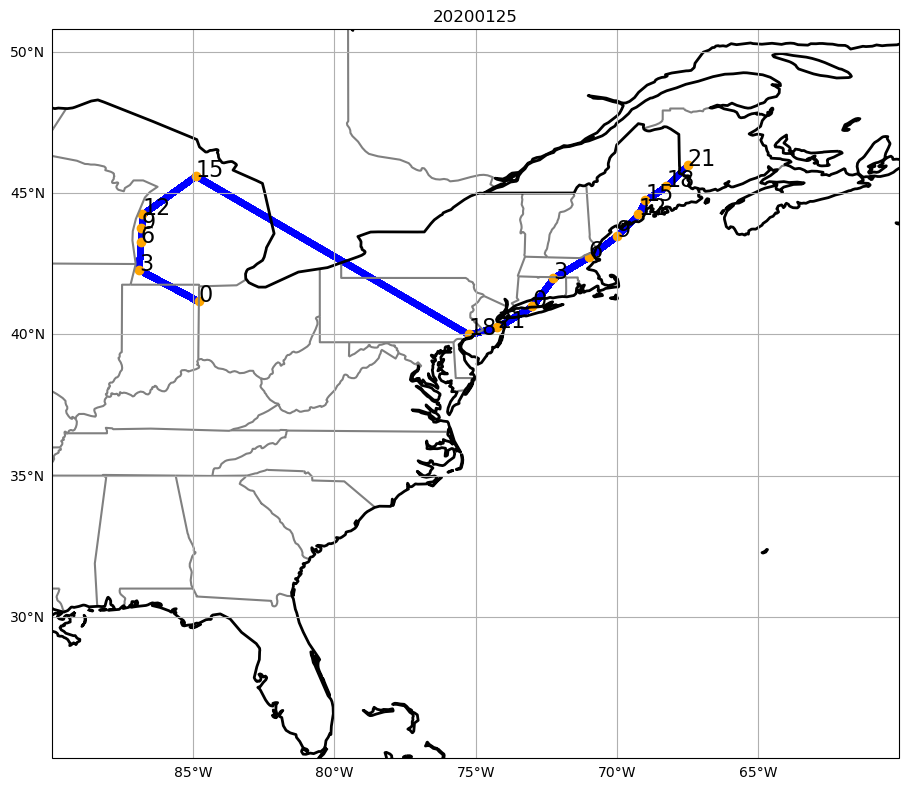

In [14]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-73.5)) #central_latitude=44.25))
ax.set_extent([west_lon, east_lon, south_lat, north_lat])
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m', facecolor='none', linewidth=1.5)
ax.add_feature(states_provinces, edgecolor='grey')#, zorder=10)
ax.coastlines(linewidth=2)
ax.add_feature(cfeature.BORDERS,linewidth=2)
g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
g1.xlabels_top=False
g1.ylabels_right=False

ax.scatter(lowsubdf_1s['Lon'],lowsubdf_1s['Lat'], marker='.',color='blue',transform = ccrs.PlateCarree())
ax.scatter(lowsubdf['Longitude'],lowsubdf['Latitude'], marker='o',color='orange',transform = ccrs.PlateCarree())

annotations=list(lowsubdf.index.hour)
for i, label in enumerate(annotations):
    ax.text(lowsubdf['Longitude'][i], lowsubdf['Latitude'][i],label,size=16,transform = ccrs.PlateCarree())

plt.title(day)
plt.tight_layout()

0
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 20:00:08  1.0  40.166852 -74.582593        28.518268     297.126193
2020-01-25 20:00:09  1.0  40.166875 -74.582500        28.491183     296.957212
2020-01-25 20:00:10  1.0  40.166898 -74.582407        28.464067     296.788301
2020-01-25 20:00:11  1.0  40.166921 -74.582315        28.437954     296.620265
2020-01-25 20:00:12  1.0  40.166944 -74.582222        28.411809     296.452294
...                  ...        ...        ...              ...            ...
2020-01-25 20:16:19  1.0  40.189329 -74.492685       344.866535     187.334943
2020-01-25 20:16:20  1.0  40.189352 -74.492593       344.801742     187.308031
2020-01-25 20:16:21  1.0  40.189375 -74.492500       344.737549     187.276122
2020-01-25 20:16:22  1.0  40.189398 -74.492407       344.673333     187.244454
2020-01-25 20:16:23  1.0  40.189421 -74.492315       344.609095     187.213027

[976 rows x 5 columns]


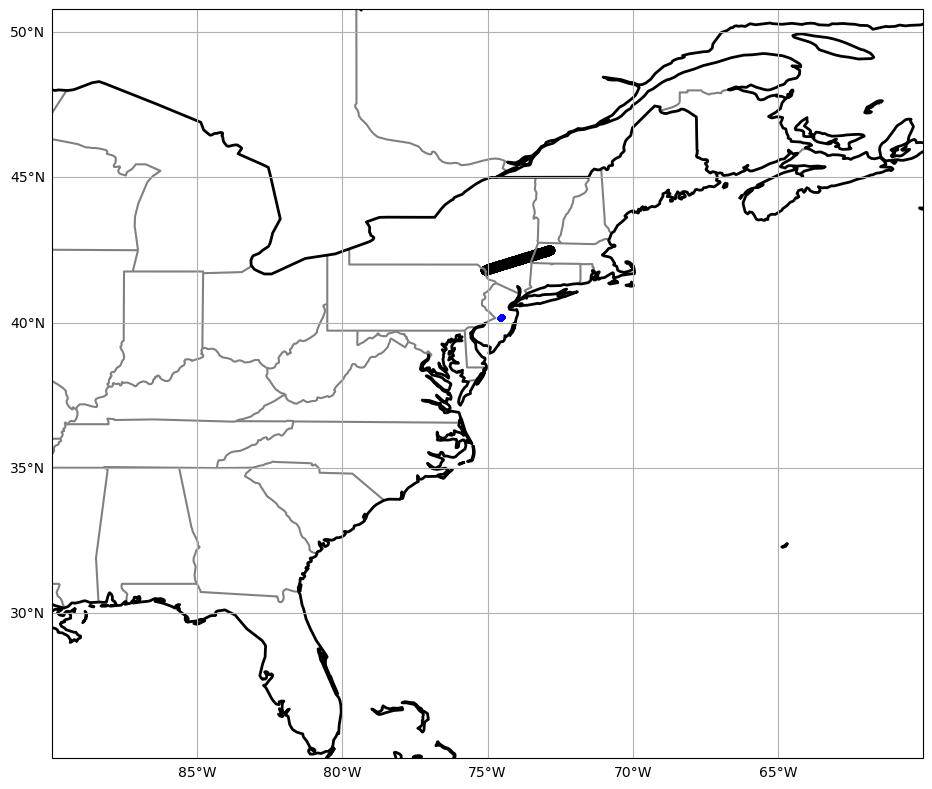

1
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 20:18:30  2.0  40.192361 -74.480556       340.568326     167.844535
2020-01-25 20:18:31  2.0  40.192384 -74.480463       340.576354     167.644864
2020-01-25 20:18:32  2.0  40.192407 -74.480370       340.584402     167.445195
2020-01-25 20:18:33  2.0  40.192431 -74.480278       340.592471     167.245529
2020-01-25 20:18:34  2.0  40.192454 -74.480185       340.600560     167.045866
...                  ...        ...        ...              ...            ...
2020-01-25 20:25:44  2.0  40.202407 -74.440370       348.100955      81.062480
2020-01-25 20:25:45  2.0  40.202431 -74.440278       348.133372      80.866704
2020-01-25 20:25:46  2.0  40.202454 -74.440185       348.169526      80.670194
2020-01-25 20:25:47  2.0  40.202477 -74.440093       348.205859      80.473715
2020-01-25 20:25:48  2.0  40.202500 -74.440000       348.242374      80.277269

[439 rows x 5 columns]


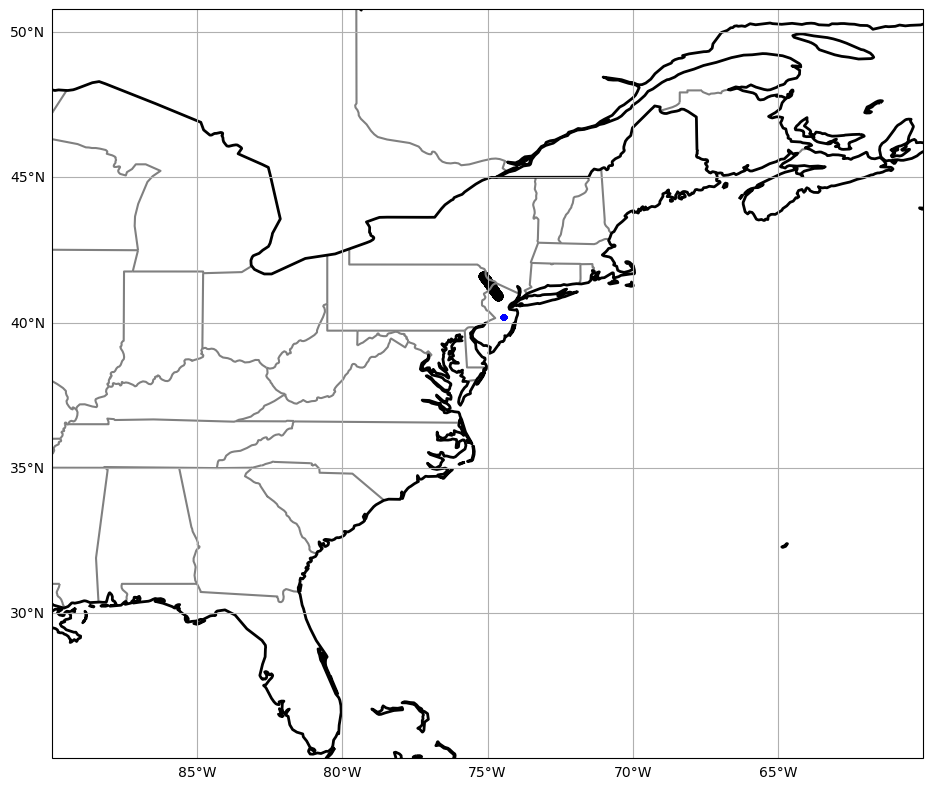

2
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 20:29:18  3.0  40.207361 -74.420556         8.340768      88.956299
2020-01-25 20:29:19  3.0  40.207384 -74.420463         8.346345      89.154410
2020-01-25 20:29:20  3.0  40.207407 -74.420370         8.351895      89.352522
2020-01-25 20:29:21  3.0  40.207431 -74.420278         8.351235      89.549756
2020-01-25 20:29:22  3.0  40.207454 -74.420185         8.350577      89.746989
...                  ...        ...        ...              ...            ...
2020-01-25 20:51:25  3.0  40.238079 -74.297685         7.904294     350.148259
2020-01-25 20:51:26  3.0  40.238102 -74.297593         7.904829     350.343347
2020-01-25 20:51:27  3.0  40.238125 -74.297500         7.905362     350.538436
2020-01-25 20:51:28  3.0  40.238148 -74.297407         7.905895     350.733524
2020-01-25 20:51:29  3.0  40.238171 -74.297315         7.906426     350.928612

[1332 rows x 5 columns]


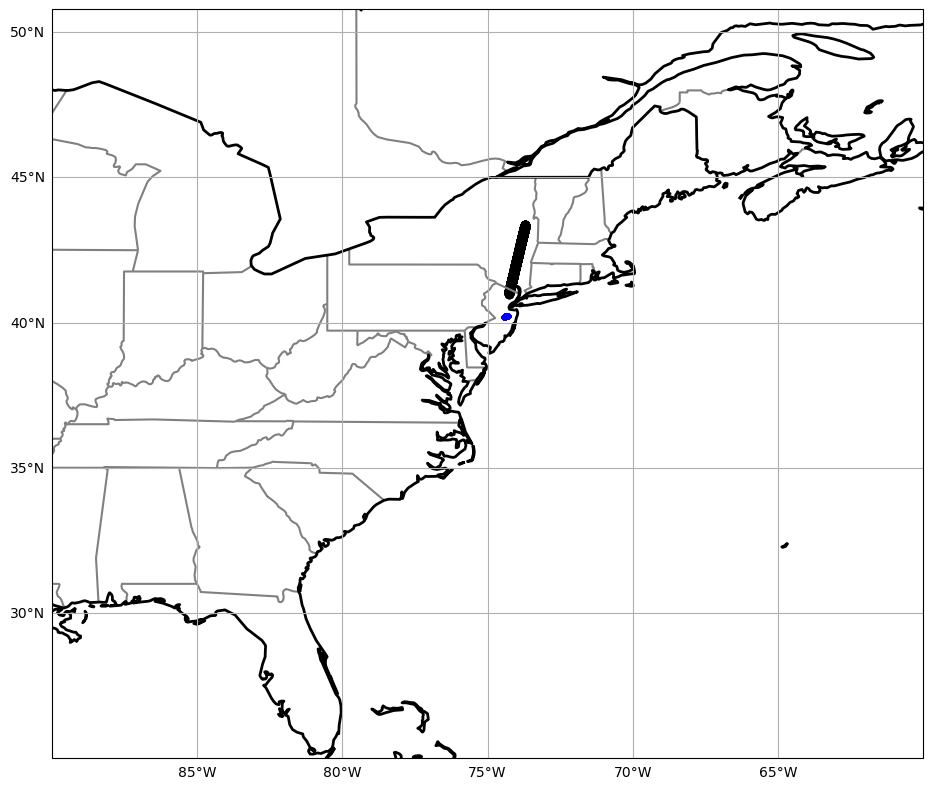

3
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 20:54:40  4.0  40.242593 -74.279630        12.341167     355.011904
2020-01-25 20:54:41  4.0  40.242616 -74.279537        12.366377     354.881826
2020-01-25 20:54:42  4.0  40.242639 -74.279444        12.391606     354.751820
2020-01-25 20:54:43  4.0  40.242662 -74.279352        12.416855     354.621887
2020-01-25 20:54:44  4.0  40.242685 -74.279259        12.442123     354.492025
...                  ...        ...        ...              ...            ...
2020-01-25 21:02:10  4.0  40.259028 -74.234954        25.518961     301.601860
2020-01-25 21:02:11  4.0  40.259097 -74.234838        25.552809     301.495416
2020-01-25 21:02:12  4.0  40.259167 -74.234722        25.586681     301.389080
2020-01-25 21:02:13  4.0  40.259236 -74.234606        25.620578     301.282854
2020-01-25 21:02:14  4.0  40.259306 -74.234491        25.654499     301.176738

[455 rows x 5 columns]


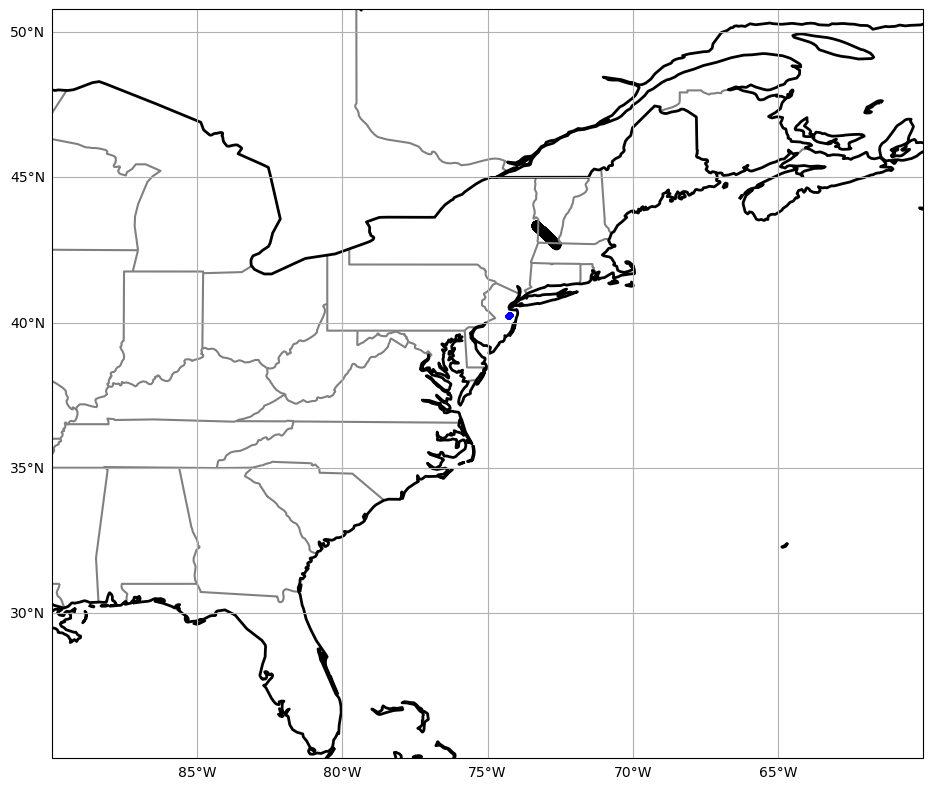

4
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 21:04:20  5.0  40.268056 -74.219907        25.379067     277.737709
2020-01-25 21:04:21  5.0  40.268125 -74.219792        25.349343     277.575847
2020-01-25 21:04:22  5.0  40.268194 -74.219676        25.319584     277.414063
2020-01-25 21:04:23  5.0  40.268264 -74.219560        25.289789     277.252357
2020-01-25 21:04:24  5.0  40.268333 -74.219444        25.259958     277.090730
...                  ...        ...        ...              ...            ...
2020-01-25 21:21:06  5.0  40.337917 -74.103472       333.800383     183.257968
2020-01-25 21:21:07  5.0  40.337986 -74.103356       333.731856     183.269967
2020-01-25 21:21:08  5.0  40.338056 -74.103241       333.663337     183.282235
2020-01-25 21:21:09  5.0  40.338125 -74.103125       333.594827     183.294772
2020-01-25 21:21:10  5.0  40.338194 -74.103009       333.526326     183.307579

[1011 rows x 5 columns]


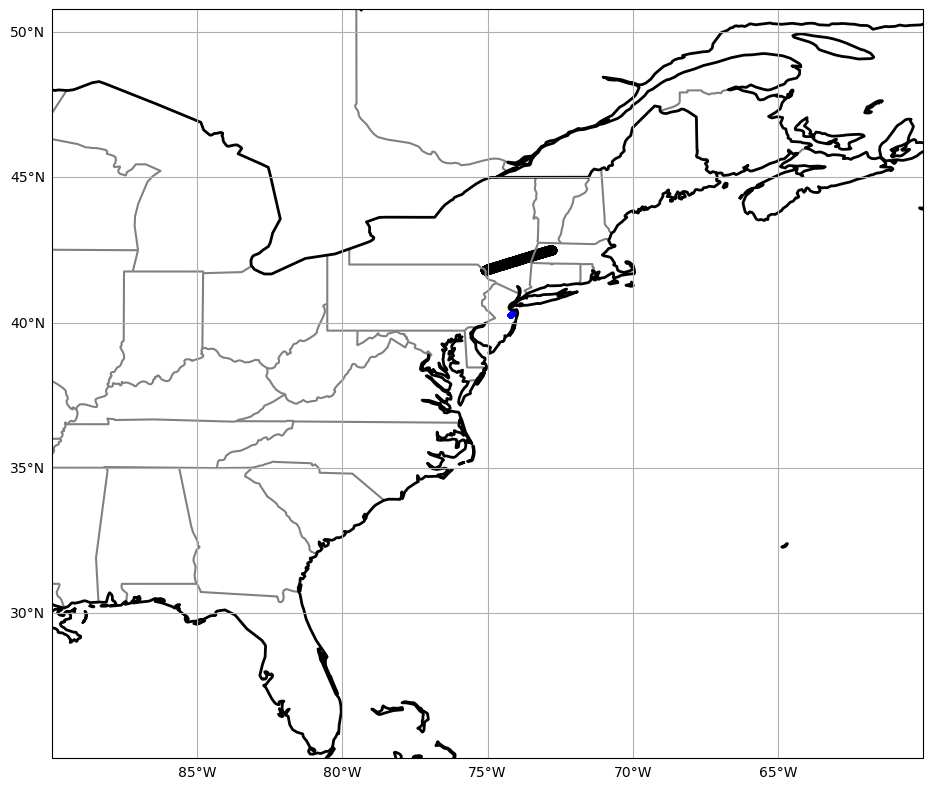

5
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 21:23:12  6.0  40.346667 -74.088889       328.253098     166.795518
2020-01-25 21:23:13  6.0  40.346736 -74.088773       328.243292     166.586470
2020-01-25 21:23:14  6.0  40.346806 -74.088657       328.233462     166.377427
2020-01-25 21:23:15  6.0  40.346875 -74.088542       328.223609     166.168386
2020-01-25 21:23:16  6.0  40.346944 -74.088426       328.213460     165.960738
...                  ...        ...        ...              ...            ...
2020-01-25 21:30:25  6.0  40.376736 -74.038773       320.199240      78.370150
2020-01-25 21:30:26  6.0  40.376806 -74.038657       320.158571      78.173981
2020-01-25 21:30:27  6.0  40.376875 -74.038542       320.117700      77.977850
2020-01-25 21:30:28  6.0  40.376944 -74.038426       320.076625      77.781757
2020-01-25 21:30:29  6.0  40.377014 -74.038310       320.035346      77.585702

[438 rows x 5 columns]


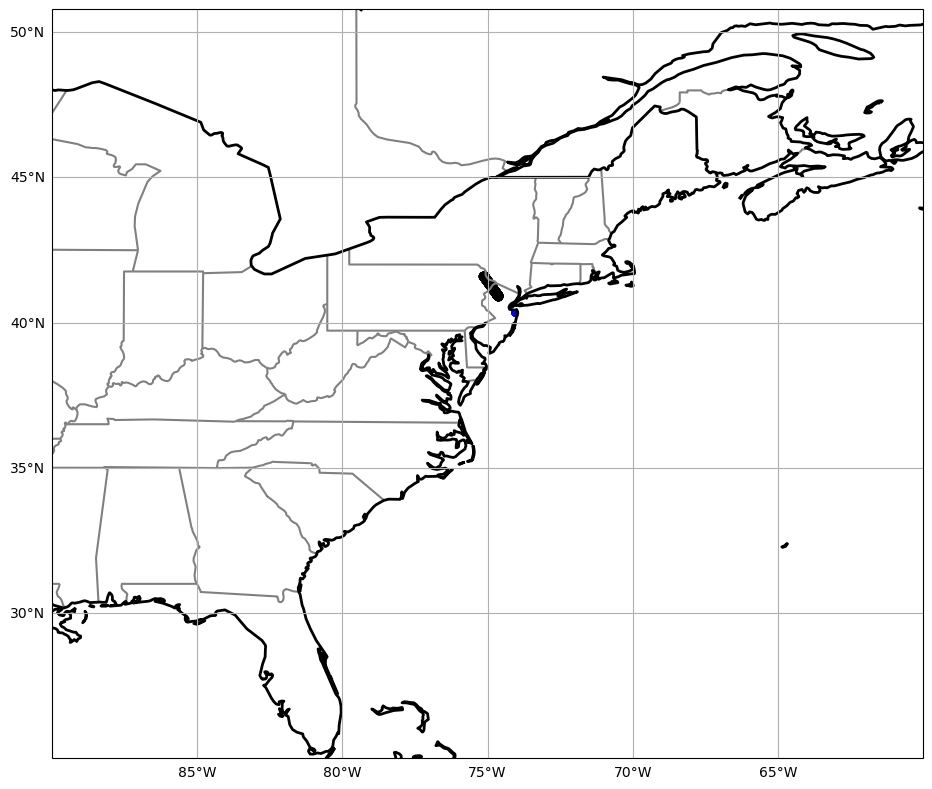

6
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 21:33:56  7.0  40.391389 -74.014352       342.720372      71.283577
2020-01-25 21:33:57  7.0  40.391458 -74.014236       342.790933      71.456886
2020-01-25 21:33:58  7.0  40.391528 -74.014120       342.861152      71.630304
2020-01-25 21:33:59  7.0  40.391597 -74.014005       342.931030      71.803830
2020-01-25 21:34:00  7.0  40.391667 -74.013889       343.000570      71.977462
...                  ...        ...        ...              ...            ...
2020-01-25 21:56:14  7.0  40.484306 -73.859491         2.264272     321.354436
2020-01-25 21:56:15  7.0  40.484375 -73.859375         2.266854     321.542463
2020-01-25 21:56:16  7.0  40.484444 -73.859259         2.269664     321.730692
2020-01-25 21:56:17  7.0  40.484514 -73.859144         2.272471     321.918922
2020-01-25 21:56:18  7.0  40.484583 -73.859028         2.275274     322.107153

[1343 rows x 5 columns]


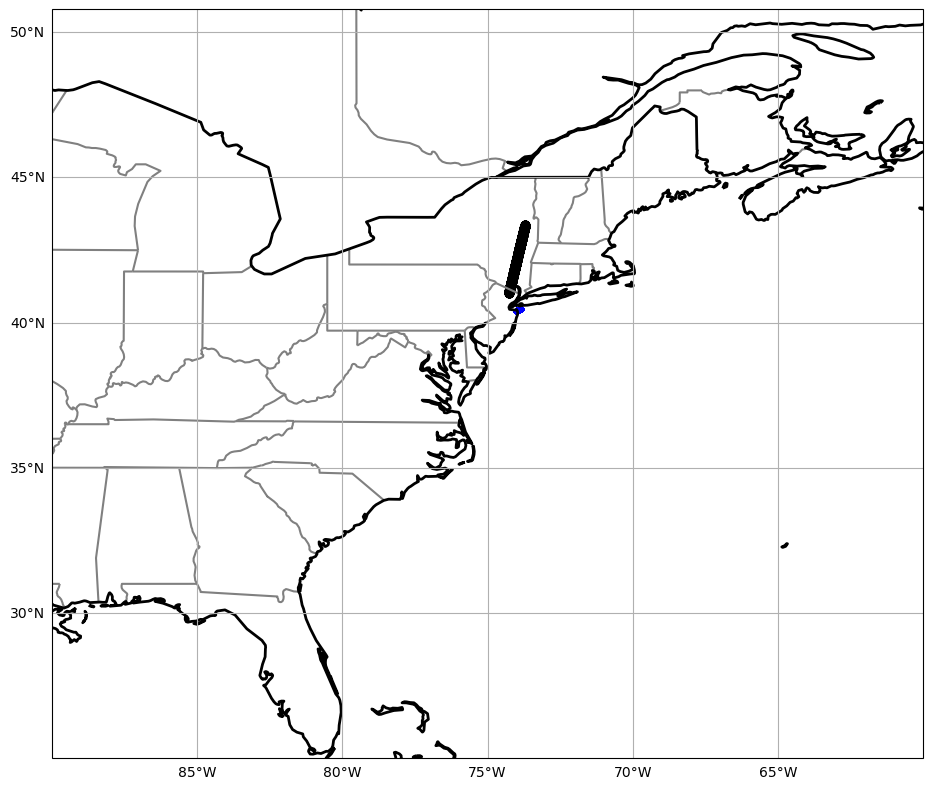

7
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 22:00:18  8.0  40.501250 -73.831250       357.543224     314.449241
2020-01-25 22:00:19  8.0  40.501319 -73.831134       357.553236     314.245048
2020-01-25 22:00:20  8.0  40.501389 -73.831019       357.563261     314.040866
2020-01-25 22:00:21  8.0  40.501458 -73.830903       357.574457     313.836282
2020-01-25 22:00:22  8.0  40.501528 -73.830787       357.585669     313.631711
...                  ...        ...        ...              ...            ...
2020-01-25 22:07:58  8.0  40.533194 -73.778009         4.901272     223.479931
2020-01-25 22:07:59  8.0  40.533264 -73.777894         4.923112     223.289076
2020-01-25 22:08:00  8.0  40.533333 -73.777778         4.944990     223.098254
2020-01-25 22:08:01  8.0  40.533403 -73.777662         4.968012     222.908384
2020-01-25 22:08:02  8.0  40.533472 -73.777546         4.991074     222.718550

[465 rows x 5 columns]


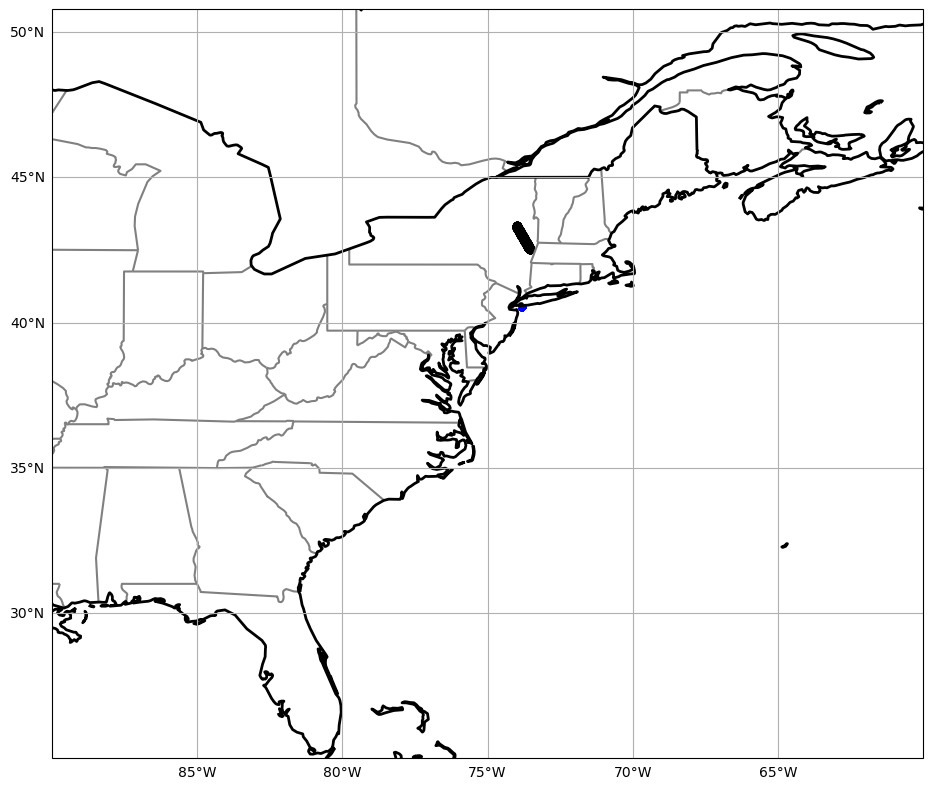

8
                      FL        Lat        Lon  Theta (Degrees)  Distance (Km)
2020-01-25 22:13:38  9.0  40.556806 -73.738657        16.333183     238.862665
2020-01-25 22:13:39  9.0  40.556875 -73.738542        16.326941     239.051011
2020-01-25 22:13:40  9.0  40.556944 -73.738426        16.320710     239.239361
2020-01-25 22:13:41  9.0  40.557014 -73.738310        16.314489     239.427486
2020-01-25 22:13:42  9.0  40.557083 -73.738194        16.308278     239.615614
...                  ...        ...        ...              ...            ...
2020-01-25 22:33:21  9.0  40.638958 -73.601736        12.563170     462.868200
2020-01-25 22:33:22  9.0  40.639028 -73.601620        12.561466     463.059541
2020-01-25 22:33:23  9.0  40.639097 -73.601505        12.559763     463.250883
2020-01-25 22:33:24  9.0  40.639167 -73.601389        12.558061     463.442224
2020-01-25 22:33:25  9.0  40.639236 -73.601273        12.556361     463.633565

[1188 rows x 5 columns]


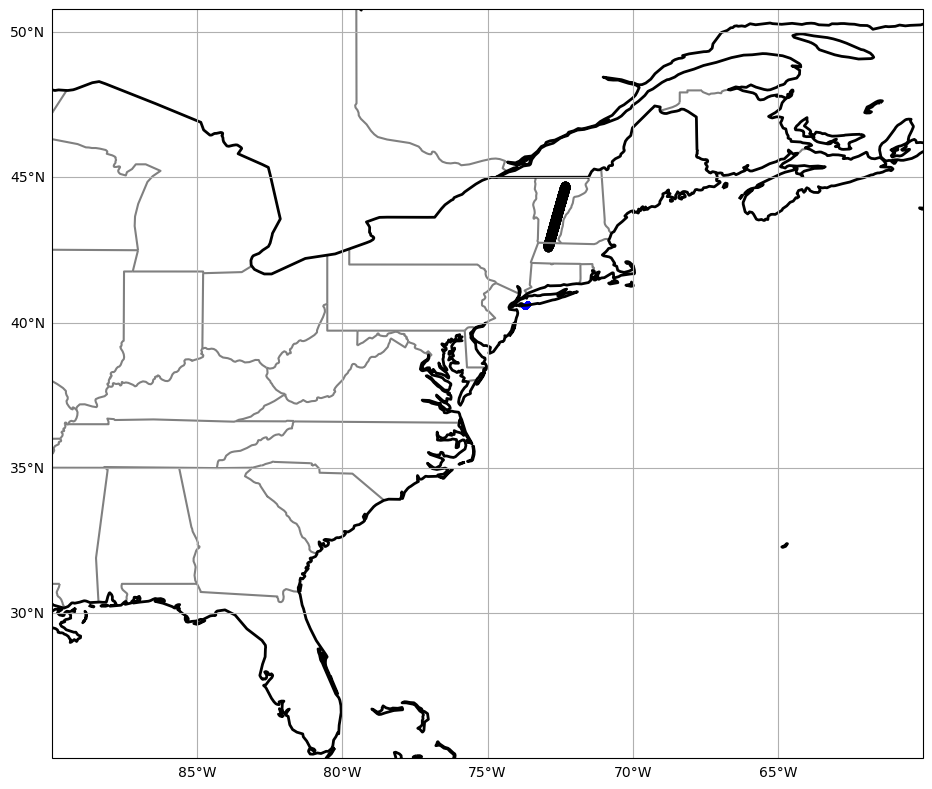

9
                       FL        Lat        Lon  Theta (Degrees)  \
2020-01-25 22:37:00  10.0  40.654167 -73.576389        16.509170   
2020-01-25 22:37:01  10.0  40.654236 -73.576273        16.525996   
2020-01-25 22:37:02  10.0  40.654306 -73.576157        16.542834   
2020-01-25 22:37:03  10.0  40.654375 -73.576042        16.559685   
2020-01-25 22:37:04  10.0  40.654444 -73.575926        16.576548   
...                   ...        ...        ...              ...   
2020-01-25 22:42:56  10.0  40.678889 -73.535185        22.164049   
2020-01-25 22:42:57  10.0  40.678958 -73.535069        22.179932   
2020-01-25 22:42:58  10.0  40.679028 -73.534954        22.195831   
2020-01-25 22:42:59  10.0  40.679097 -73.534838        22.211744   
2020-01-25 22:43:00  10.0  40.679167 -73.534722        22.227672   

                     Distance (Km)  
2020-01-25 22:37:00     453.606719  
2020-01-25 22:37:01     453.444851  
2020-01-25 22:37:02     453.283024  
2020-01-25 22:37:03     453.12123

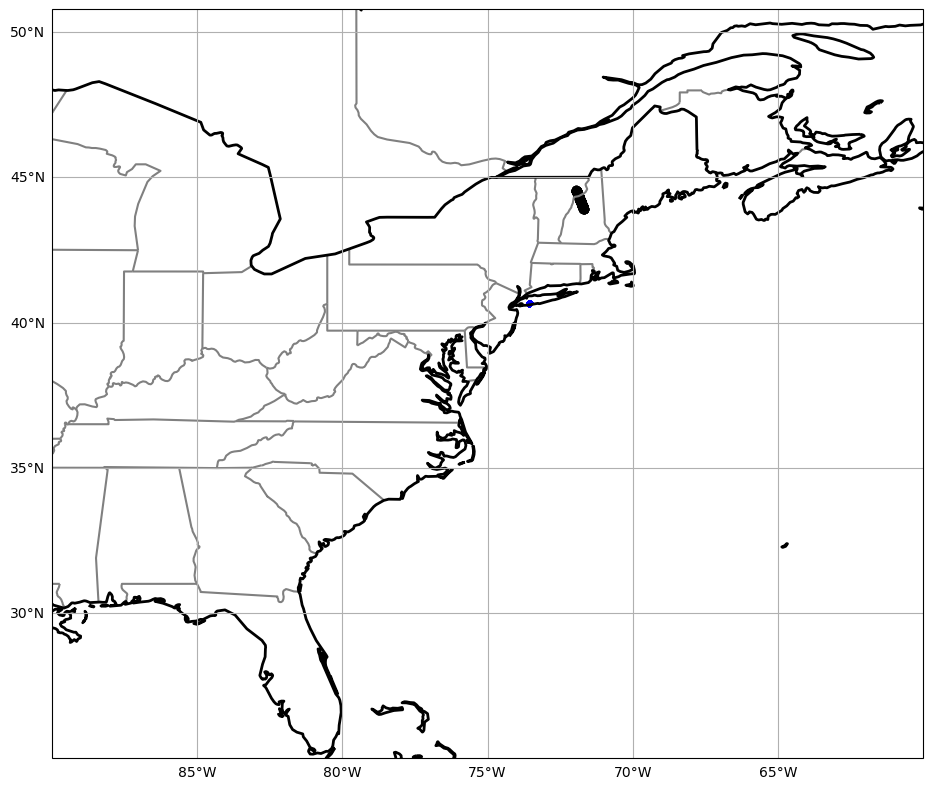

10
                       FL        Lat        Lon  Theta (Degrees)  \
2020-01-25 22:45:00  11.0  40.687500 -73.520833        21.167193   
2020-01-25 22:45:01  11.0  40.687569 -73.520718        21.146461   
2020-01-25 22:45:02  11.0  40.687639 -73.520602        21.125707   
2020-01-25 22:45:03  11.0  40.687708 -73.520486        21.104933   
2020-01-25 22:45:04  11.0  40.687778 -73.520370        21.084139   
...                   ...        ...        ...              ...   
2020-01-25 22:59:56  11.0  40.749722 -73.417130       351.097946   
2020-01-25 22:59:57  11.0  40.749792 -73.417014       351.090614   
2020-01-25 22:59:58  11.0  40.749861 -73.416898       351.083269   
2020-01-25 22:59:59  11.0  40.749931 -73.416782       351.075913   
2020-01-25 23:00:00  11.0  40.750000 -73.416667       351.068544   

                     Distance (Km)  
2020-01-25 22:45:00     366.873580  
2020-01-25 22:45:01     366.701989  
2020-01-25 22:45:02     366.530448  
2020-01-25 22:45:03     366.3589

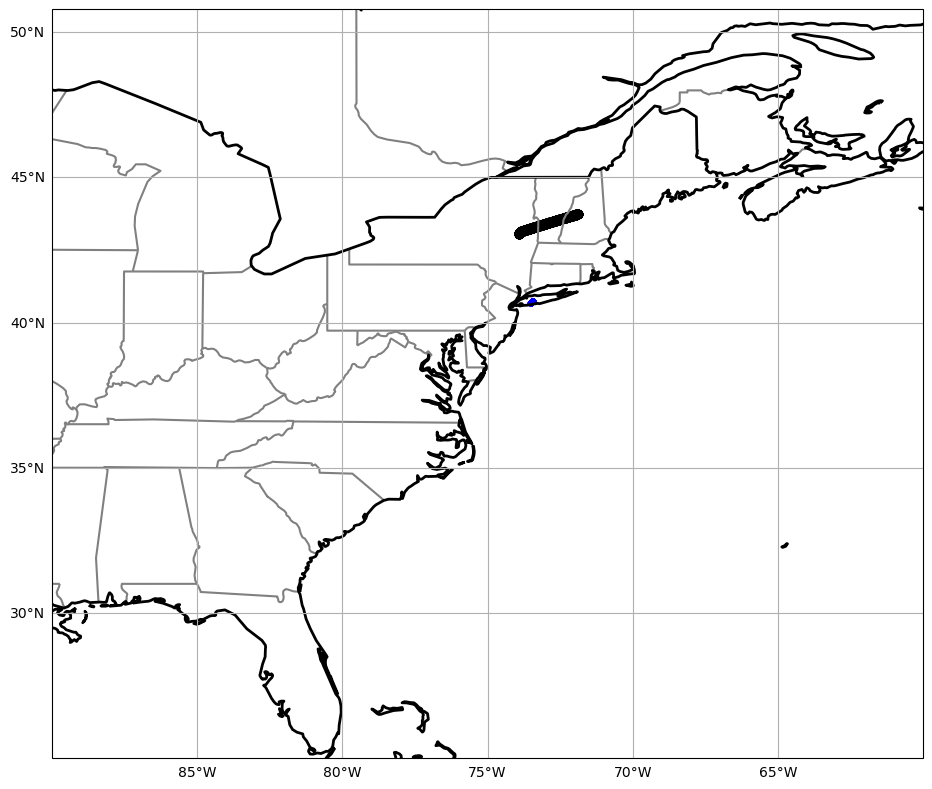

In [15]:
df_lst_er2=[]
for n in range(len(fls)):
    leg_start=fls[n][0]
    leg_end=fls[n][1]
    
    ft_dfinterp_sub=ft_dfinterp.between_time(leg_start[11:], leg_end[11:])#, include_start=True, include_end=True)
    lowinterp1=lowsubdf_1s.between_time(leg_start[11:], leg_end[11:])#, include_start=True, include_end=True)

    lowinterp2s=[]
    dates2s=[]
    for n2 in range(lowinterp1.shape[0]):
        if d[0]==lowinterp1.index.day[n2]:
            lowinterp2s.append(lowinterp1.iloc[n2])
            dates2s.append(lowinterp1.index[n2])

    lowinterp_sub=pd.DataFrame(np.asarray(lowinterp2s))
    lowinterp_sub.columns=lowinterp1.columns
    lowinterp_sub.index=dates2s

    theta_a=np.zeros(ft_dfinterp_sub.shape[0])
    r_a=np.zeros(ft_dfinterp_sub.shape[0])
    for j in range(ft_dfinterp_sub.shape[0]):
        theta=bearing(lowinterp_sub['Lat'][j],ft_dfinterp_sub['Lat'][j], lowinterp_sub['Lon'][j], ft_dfinterp_sub['Lon'][j])
        r=haversine((lowinterp_sub['Lat'][j],lowinterp_sub['Lon'][j]), (ft_dfinterp_sub['Lat'][j],ft_dfinterp_sub['Lon'][j]), unit='km')
        theta_a[j]=theta
        r_a[j]=r
    print(n)   
    theta_r_df=pd.DataFrame(data={'FL':float(fls[n][2]),'Lat':lowinterp_sub['Lat'],'Lon':lowinterp_sub['Lon'],'Theta (Degrees)': theta_a,'Distance (Km)':r_a}, index=ft_dfinterp_sub.index.values)
    df_lst_er2.append(theta_r_df)
    print(theta_r_df)
    
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-73.5)) #central_latitude=44.25))
    ax.set_extent([west_lon, east_lon, south_lat, north_lat])
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m', facecolor='none', linewidth=1.5)
    ax.add_feature(states_provinces, edgecolor='grey')#, zorder=10)
    ax.coastlines(linewidth=2)
    ax.add_feature(cfeature.BORDERS,linewidth=2)
    g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
    g1.xlabels_top=False
    g1.ylabels_right=False

    ax.scatter(lowinterp_sub['Lon'][:],lowinterp_sub['Lat'][:], marker='.',color='blue',transform = ccrs.PlateCarree())
    ax.scatter(ft_dfinterp_sub['Lon'][:],ft_dfinterp_sub['Lat'][:],marker='o',color='black',transform = ccrs.PlateCarree())
    plt.tight_layout()
    plt.show()

df_final_theta_r=pd.concat(df_lst_er2)

## Calculating Cyclone Pressure Gradient

In [16]:
# Assigning latidue/longitude bounds to search for lowest pressure over
lat_bd1=35
lat_bd2=50
lon_bd1=-70
lon_bd2=-80

#### Finding the location of the lowest pressure associated with the cyclone

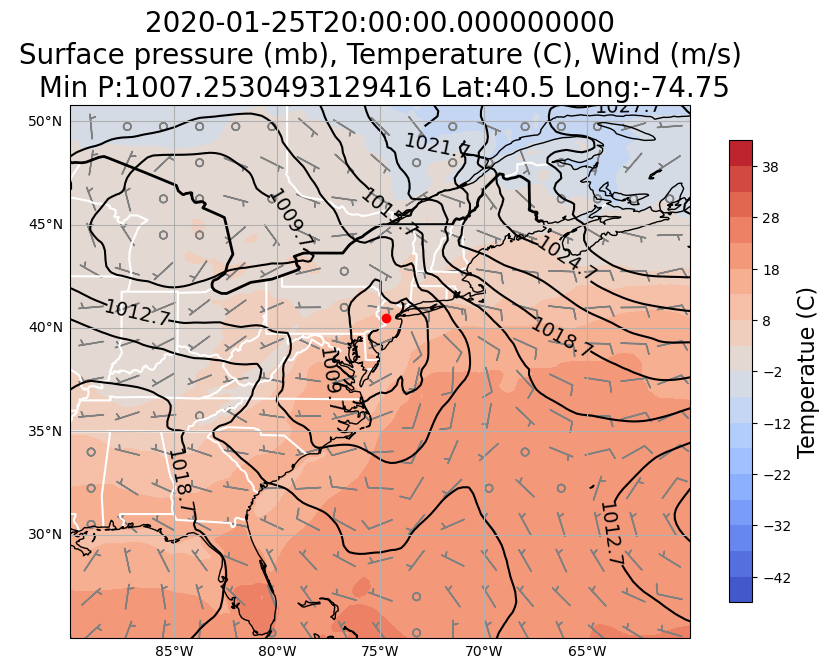

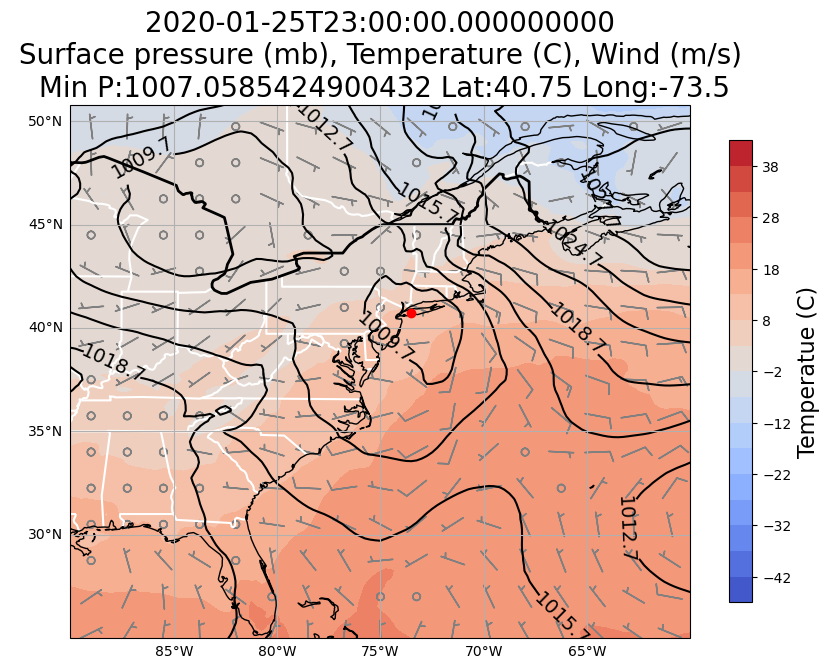

In [17]:
min_time=[]
min_lat=[]
min_lon=[]
min_p=[]
xpt=[]
ypt=[]
for n in range(len(era_idx_3hr)):
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-73.5)) #central_latitude=44.25))
    ax.set_extent([west_lon, east_lon, south_lat, north_lat])
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m', facecolor='none', linewidth=1.5)
    ax.add_feature(states_provinces, edgecolor='white')#, zorder=10)
    ax.coastlines(linewidth=1)
    ax.add_feature(cfeature.BORDERS,linewidth=2)
    g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
    g1.xlabels_top=False
    g1.ylabels_right=False
               
    i=era_idx_3hr[n]

    p=ax.contour(lon_s,lat_s,press[i,:,:],colors='black',linewidth=3,levels=np.arange(np.min(press)-100, np.max(press)+100,3),transform = ccrs.PlateCarree())
    ax.clabel(p, fontsize=14)
                 
    pm=ax.contourf(lon_s, lat_s, temp_s[i,:,:],cmap='coolwarm',alpha=1,levels=np.arange(-47, 45,5),transform = ccrs.PlateCarree())
    cb = plt.colorbar(pm, shrink=.75)
    cb.set_label(label='Temperatue (C)',fontsize=16) 
    
    
    X, Y = np.meshgrid(lon_s, lat_s)

    ax.barbs(X[::7,::7], Y[::7,::7], u_s[i,::7,::7], v_s[i,::7,::7], color='gray',length=6, linewidth=1.1, pivot='middle',transform = ccrs.PlateCarree())
    
    minp=9999999
    lat_min=2
    lon_min=2
    xpt_min=0
    ypt_min=0
    for j in range(press[i,:,:].shape[0]):
        for k in range(press[i,:,:].shape[1]):
            if lat_s[j]>lat_bd1:
                if lat_s[j]<lat_bd2:
                    if lon_s[k]<lon_bd1:
                        if lon_s[k]>lon_bd2:
                            if press[i,j,k]<minp:
                                minp=press[i,j,k]
                                lat_min=lat_s[j]
                                lon_min=lon_s[k]
                                xpt_min=j
                                ypt_min=k
                
    ax.plot(lon_min, lat_min, marker='o', color='red', transform=ccrs.PlateCarree())
    
    min_time.append(time_s[i])
    min_lat.append(lat_min)
    min_lon.append(lon_min)
    min_p.append(minp)
    xpt.append(xpt_min)
    ypt.append(ypt_min)
    
    ax.set_title(str(time_s[i])+'\n Surface pressure (mb), Temperature (C), Wind (m/s) \n Min P:'+str(minp)+' Lat:'+str(lat_min)+' Long:'+str(lon_min), fontsize=20)

    plt.show()

In [18]:
df_pgrad=pd.DataFrame([min_lat[:], min_lon[:], min_p[:],xpt[:], ypt[:]]).T
df_pgrad=df_pgrad.rename(columns={0: 'Min Lat', 1: 'Min Lon', 2:'Min P',3:'X pt',4:'Y Pt'})
df_pgrad.index=min_time[:]
df_pgrad

,Min Lat,Min Lon,Min P,X pt,Y Pt
2020-01-25 20:00:00,40.50,-74.75,1007.253049,58.0,141.0
2020-01-25 23:00:00,40.75,-73.50,1007.058542,57.0,146.0


#### Calculating Pressure Gradient of Cyclone
Takes the location of the lowest pressure point and finds points at each radial at a distance defined by d

In [19]:
# Defining number of radials and over what distance the pressure gradient is calculated

radials=np.arange(0,405,45)
d=200
R=6371

The pressure Gradient is 0.014577 mb/km
The pressure Gradient is 0.014214 mb/km


,Min Lat,Min Lon,Min P,X pt,Y Pt,Press Grad (mb/km)
2020-01-25 20:00:00,40.50,-74.75,1007.253049,58.0,141.0,0.014577
2020-01-25 23:00:00,40.75,-73.50,1007.058542,57.0,146.0,0.014214


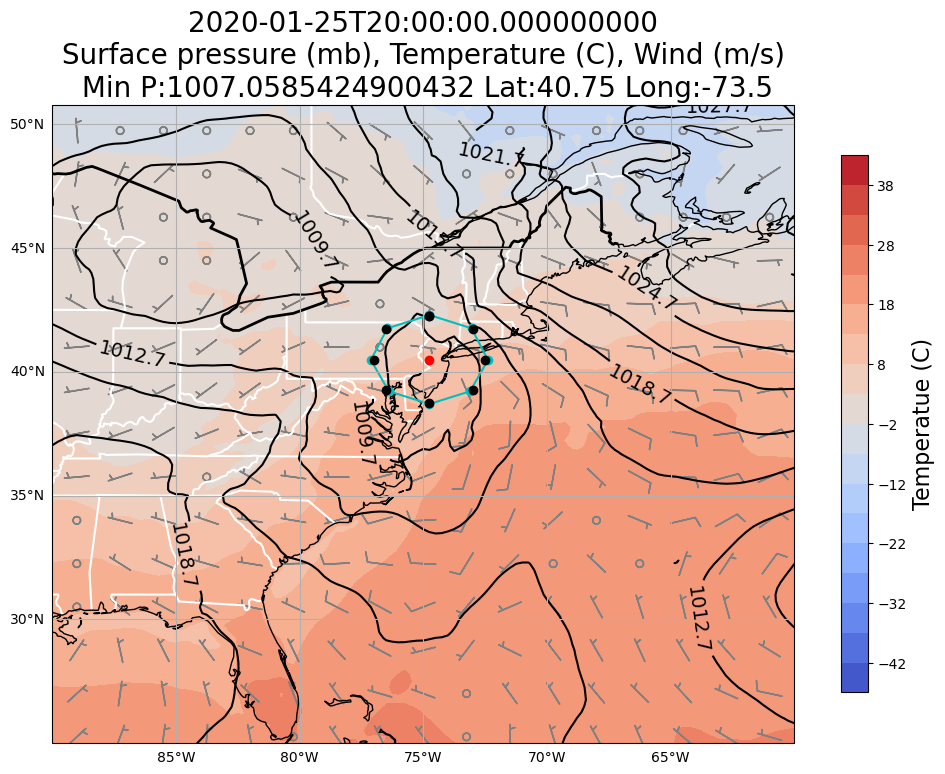

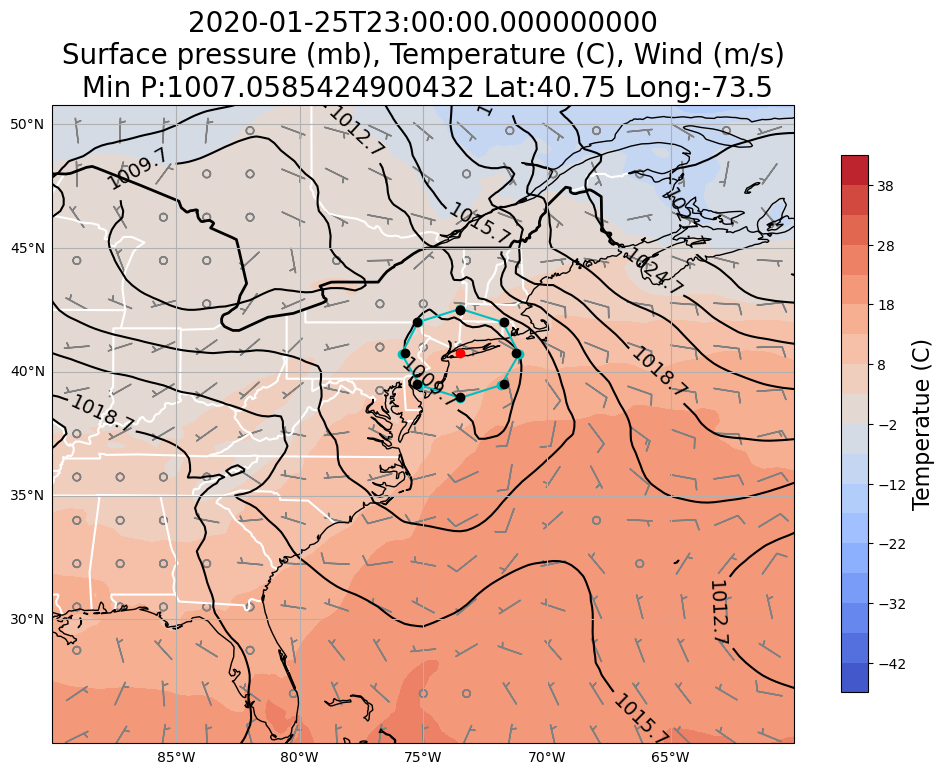

In [20]:
pressgrad=np.zeros(df_pgrad.shape)
for a in range(df_pgrad.shape[0]):
    distmin=np.ones(radials.shape[0])*99999999999
    idxj=np.ones(radials.shape[0])
    idxk=np.ones(radials.shape[0])
    lat200=np.ones(radials.shape[0])
    lon200=np.ones(radials.shape[0])
    
    # Finding 200 km  circle around min p
    for n in range(radials.shape[0]):
        distlst=[]
        for j in range(lat_s.shape[0]):
            for k in range(lon_s.shape[0]):
                lat2,lon2=get_point_at_distance(df_pgrad['Min Lat'][a],df_pgrad['Min Lon'][a], d, radials[n], R)
                dist=great_circle([lat2,lat_s[j]], [lon2, lon_s[k]])
                lat200[n]=lat2
                lon200[n]=lon2
                if dist<distmin[n]:
                    distmin[n]=dist
                    idxj[n]=j
                    idxk[n]=k
    # Plotting               
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-73.5)) #central_latitude=44.25))
    ax.set_extent([west_lon, east_lon, south_lat, north_lat])
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='50m', facecolor='none', linewidth=1.5)
    ax.add_feature(states_provinces, edgecolor='white')#, zorder=10)
    ax.coastlines(linewidth=1)
    ax.add_feature(cfeature.BORDERS,linewidth=2)
    g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
    g1.xlabels_top=False
    g1.ylabels_right=False
    
    i=era_idx_3hr[a]

    p=ax.contour(lon_s,lat_s,press[i,:,:],colors='black',linewidth=3,levels=np.arange(np.min(press)-100, np.max(press)+100,3),transform = ccrs.PlateCarree())
    ax.clabel(p, fontsize=14)

    pm=ax.contourf(lon_s, lat_s, temp_s[i,:,:],cmap='coolwarm',alpha=1,levels=np.arange(-47, 45,5),transform = ccrs.PlateCarree())
    cb = plt.colorbar(pm, shrink=.75)
    cb.set_label(label='Temperatue (C)',fontsize=16) 

    X, Y = np.meshgrid(lon_s, lat_s)
    ax.barbs(X[::7,::7], Y[::7,::7], u_s[i,::7,::7], v_s[i,::7,::7], color='gray',length=6, linewidth=1.1, pivot='middle',transform = ccrs.PlateCarree())

    ax.plot(df_pgrad['Min Lon'].values[a], df_pgrad['Min Lat'].values[a], marker='o', color='red', transform=ccrs.PlateCarree())
    ax.plot(lon200,lat200, marker='o', color='c', transform=ccrs.PlateCarree())
    for p in range(len(radials)):
        ax.plot(lon_s[int(idxk[p])],lat_s[int(idxj[p])], marker='o', color='k', transform=ccrs.PlateCarree())

    ax.set_title(str(time_s[i])+'\n Surface pressure (mb), Temperature (C), Wind (m/s) \n Min P:'+str(minp)+' Lat:'+str(lat_min)+' Long:'+str(lon_min), fontsize=20)
    plt.tight_layout()

    # Saving data
    pressval=np.zeros(radials.shape[0])
    for n in range(radials.shape[0]):
        pressval[n]=press[i,int(idxj[n]), int(idxk[n])]
        
    distances=np.zeros(radials.shape[0])
    for n in range(radials.shape[0]):
        distances[n]=great_circle([lat_min,lat_s[int(idxj[n])]], [lon_min, lon_s[int(idxk[n])]])/1000
        
    gradient=(np.mean(pressval)-minp)/np.mean(distances)
    print('The pressure Gradient is %f mb/km'%gradient)
    
    pressgrad[a]=gradient

df_pgrad['Press Grad (mb/km)']=pressgrad[:,0]
df_pgrad

In [21]:
df_pgradexp=df_pgrad.resample('1S').first()

df_pgradinterp=pd.DataFrame() 
df_pgradinterp['Min Lat']=df_pgradexp['Min Lat'].interpolate() 
df_pgradinterp['Min Lon']=df_pgradexp['Min Lon'].interpolate() 
df_pgradinterp['P min']=df_pgradexp['Min P'].interpolate()
df_pgradinterp['Press Grad (mb/km)']=df_pgradexp['Press Grad (mb/km)'].interpolate()

#lowinterp
df_pgradinterp

,Min Lat,Min Lon,P min,Press Grad (mb/km)
2020-01-25 20:00:00,40.500000,-74.750000,1007.253049,0.014577
2020-01-25 20:00:01,40.500023,-74.749884,1007.253031,0.014577
2020-01-25 20:00:02,40.500046,-74.749769,1007.253013,0.014577
2020-01-25 20:00:03,40.500069,-74.749653,1007.252995,0.014577
2020-01-25 20:00:04,40.500093,-74.749537,1007.252977,0.014577
...,...,...,...,...
2020-01-25 22:59:56,40.749907,-73.500463,1007.058615,0.014214
2020-01-25 22:59:57,40.749931,-73.500347,1007.058597,0.014214
2020-01-25 22:59:58,40.749954,-73.500231,1007.058579,0.014214
2020-01-25 22:59:59,40.749977,-73.500116,1007.058560,0.014214


In [22]:
df_lst_pgrad=[]
#for n in range(len(fls)):
for n in range(1):
    n=0
    leg_start=fls[n][0]
    leg_end=fls[n][1]
    
    ft_dfinterp_sub=ft_dfinterp.between_time(leg_start[11:], leg_end[11:])#, include_start=True, include_end=True)
    pgradinterp=df_pgradinterp.between_time(leg_start[11:], leg_end[11:])#, include_start=True, include_end=True)
    tog=pd.concat([ft_dfinterp_sub,pgradinterp], axis=1)
    #pgradinterp=pgradinterp.drop(columns=['Min Lat', 'Min Lon'])
    df_lst_pgrad.append(tog)
df_pgrad_final=pd.concat(df_lst_pgrad)
df_pgrad_final

,Lon,Lat,Min Lat,Min Lon,P min,Press Grad (mb/km)
2020-01-25 20:00:08,-72.852515,42.502122,40.500185,-74.749074,1007.252905,0.014576
2020-01-25 20:00:09,-72.854929,42.501449,40.500208,-74.748958,1007.252887,0.014576
2020-01-25 20:00:10,-72.857344,42.500776,40.500231,-74.748843,1007.252869,0.014576
2020-01-25 20:00:11,-72.859696,42.500085,40.500255,-74.748727,1007.252851,0.014576
2020-01-25 20:00:12,-72.862049,42.499394,40.500278,-74.748611,1007.252833,0.014576
...,...,...,...,...,...,...
2020-01-25 20:16:19,-75.082743,41.814166,40.522662,-74.636690,1007.235418,0.014544
2020-01-25 20:16:20,-75.085026,41.813445,40.522685,-74.636574,1007.235400,0.014544
2020-01-25 20:16:21,-75.087268,41.812684,40.522708,-74.636458,1007.235382,0.014544
2020-01-25 20:16:22,-75.089510,41.811923,40.522731,-74.636343,1007.235364,0.014544


## Making Final DataFrame

In [23]:
final_df=pd.concat([df_final_theta_r, df_pgrad_final], axis=1)
final_df

,FL,Lat,Lon,Theta (Degrees),Distance (Km),Lon,Lat,Min Lat,Min Lon,P min,Press Grad (mb/km)
2020-01-25 20:00:08,1.0,40.166852,-74.582593,28.518268,297.126193,-72.852515,42.502122,40.500185,-74.749074,1007.252905,0.014576
2020-01-25 20:00:09,1.0,40.166875,-74.582500,28.491183,296.957212,-72.854929,42.501449,40.500208,-74.748958,1007.252887,0.014576
2020-01-25 20:00:10,1.0,40.166898,-74.582407,28.464067,296.788301,-72.857344,42.500776,40.500231,-74.748843,1007.252869,0.014576
2020-01-25 20:00:11,1.0,40.166921,-74.582315,28.437954,296.620265,-72.859696,42.500085,40.500255,-74.748727,1007.252851,0.014576
2020-01-25 20:00:12,1.0,40.166944,-74.582222,28.411809,296.452294,-72.862049,42.499394,40.500278,-74.748611,1007.252833,0.014576
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-25 22:59:56,11.0,40.749722,-73.417130,351.097946,258.723664,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25 22:59:57,11.0,40.749792,-73.417014,351.090614,258.509673,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25 22:59:58,11.0,40.749861,-73.416898,351.083269,258.295686,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25 22:59:59,11.0,40.749931,-73.416782,351.075913,258.081703,NaN,NaN,NaN,NaN,NaN,NaN


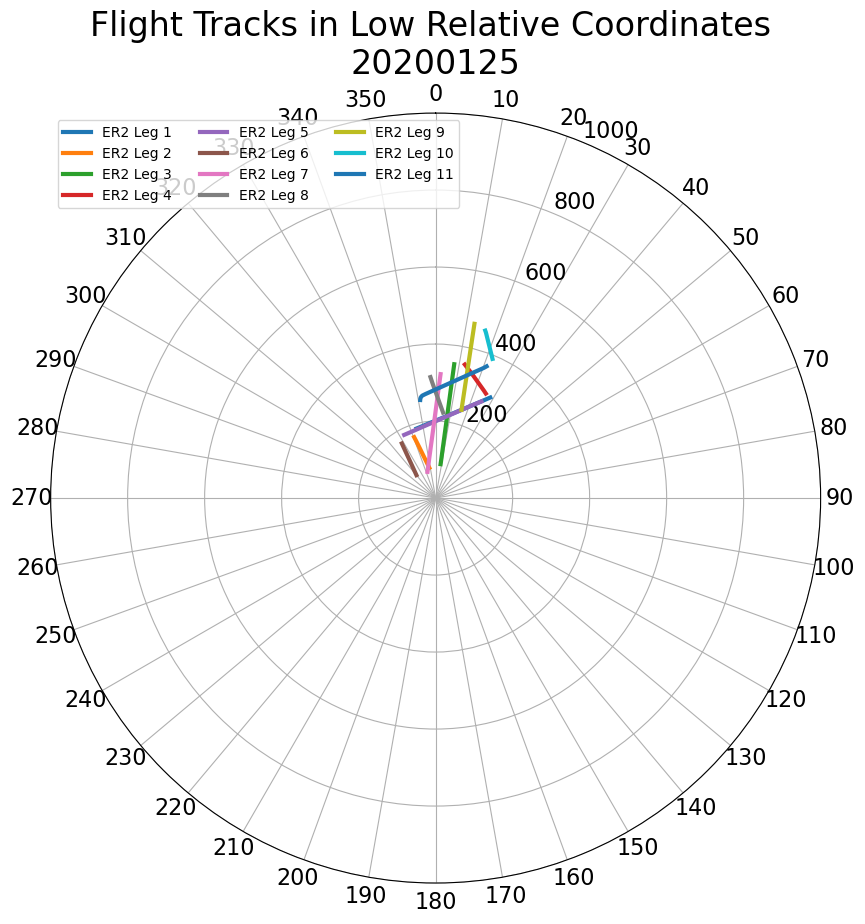

In [24]:
fig=plt.figure(figsize =(20, 10))
ax=fig.add_subplot(polar=True)
ax.tick_params(which='both', labelsize=16)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_ylim(0,1000)
ax.set_title('Flight Tracks in Low Relative Coordinates \n'+day, fontsize=24)

lines, labels = plt.thetagrids(np.arange(0,360, 10), np.arange(0,360, 10))

for n in range(len(fls)):
    leg_start=fls[n][0]
    leg_end=fls[n][1]
    
    df_final_ft=final_df.between_time(leg_start[11:], leg_end[11:])
    ax.plot(np.radians(df_final_ft['Theta (Degrees)']), df_final_ft['Distance (Km)'], label=fl_choice+" Leg "+fls[n][2], linewidth=3)
    
ax.legend(loc='upper left', ncol=3)

# Save Files

In [42]:
final_df.to_csv(path+'/LR_CycloneStrength_Files/'+fl_choice+'_'+day+'.csv')

In [ ]:
df_pgrad_final